<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/pytorch_l1_prox_backward_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla T4
0
0


# L1Loss backward with prox (soft thresholding)

In [0]:
soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0, device=device).float())

class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input


class L1Loss(torch.nn.Module):
    def __init__(self, lw=1.):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


# Demonstration 1: observe gradients
### Auto differentiation vs. proximal operation

In [0]:
torch.cuda.empty_cache()
#D = torch.autograd.Variable(torch.randn(32,40000,60, device=device), requires_grad=True)
D = torch.autograd.Variable(torch.randn(2,3,5, device=device), requires_grad=True)
Dr = torch.autograd.Variable(D, requires_grad=True)

In [4]:
ll = 0.5 * torch.ones(3,5, device=device)
print('lambda = \n', ll)
#lw = ll.clone()
lw = torch.autograd.Variable(ll, requires_grad=True)
lwr = torch.autograd.Variable(ll, requires_grad=True)

# l1 norm and its backprop
from time import time
t0 = time()

l1loss = L1Loss(lw=lw)
loss = l1loss.forward(D)
loss.backward(retain_graph=True)
print('done in %.2fms' % ((time() - t0)*1000))
print('l1 loss = ', loss.item())

lw_sum_abs = torch.sum(torch.abs(lwr*Dr))
lw_sum_abs.backward(retain_graph=True)
print('sum of abs = ', lw_sum_abs.item())

lambda = 
 tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]], device='cuda:0')
done in 1.85ms
l1 loss =  12.025116920471191
sum of abs =  12.025116920471191


### Prox of L1 norm provides gradients that cut down (sparsify) the data entries by the weight lambda while the autorgad cannot.  Imagine the gradient descent (D$-$D.grad).


In [5]:
print('data = \n', D)
print('\n Gradient of l1loss w.r.t. data by prox = \n', D.grad)
print('\n Gradient of l1loss w.r.t. lambda = \n', l1loss.lw.grad)
print('\n data = \n', Dr)
print('\n Gradient of sum of abs w.r.t. data by autograd = \n', Dr.grad)
print('\n Gradient of  sum of abs w.r.t. lambda = \n', lwr.grad)

data = 
 tensor([[[ 1.1353e+00,  1.3282e+00, -5.8815e-01,  5.7495e-01,  1.3895e-01],
         [-1.7246e-02,  1.3266e+00, -1.6707e+00,  1.9355e+00,  8.0975e-01],
         [-1.1734e+00,  8.0983e-01,  9.6734e-01, -7.7033e-01,  7.9404e-04]],

        [[-1.4144e+00,  6.2223e-01,  1.5243e-01, -4.4070e-01, -8.2730e-01],
         [-1.5615e+00,  1.0896e-02,  2.7142e-01,  1.4219e+00, -1.3293e+00],
         [ 9.6895e-01,  8.0851e-01, -4.8593e-01, -4.2631e-01, -6.1392e-02]]],
       device='cuda:0', requires_grad=True)

 Gradient of l1loss w.r.t. data by prox = 
 tensor([[[ 0.5000,  0.5000, -0.5000,  0.5000,  0.1389],
         [-0.0172,  0.5000, -0.5000,  0.5000,  0.5000],
         [-0.5000,  0.5000,  0.5000, -0.5000,  0.0008]],

        [[-0.5000,  0.5000,  0.1524, -0.4407, -0.5000],
         [-0.5000,  0.0109,  0.2714,  0.5000, -0.5000],
         [ 0.5000,  0.5000, -0.4859, -0.4263, -0.0614]]], device='cuda:0')

 Gradient of l1loss w.r.t. lambda = 
 tensor([[2.5497, 1.9504, 0.7406, 1.0157, 0.966

# Demonstration 2: minimize l1 loss $$\mbox{Minimize}_X\|X-D\|_1$$
###Note that L1Loss is not differentiable at boundaries of orthants, so augograd cannot find the minimizer.

In [6]:
D = torch.randn(2,3,5, device=device)
print('D = \n', D)

D = 
 tensor([[[ 1.0594,  0.0580, -0.5124, -1.2920, -0.4186],
         [ 1.9617, -0.0399, -1.3206, -1.9506,  0.5958],
         [ 0.5408,  0.5340,  0.6775,  1.4387,  0.2808]],

        [[-0.4491, -0.6998, -0.4308,  0.7390, -0.1533],
         [ 0.1365, -0.7922, -1.2757, -0.6266, -0.1521],
         [ 0.5217,  1.4146,  2.2457, -2.2109,  0.7326]]], device='cuda:0')


lambda = 
 0.5
[  1/10]: loss = 19.8762,  
[  2/10]: loss = 13.1127,  
[  3/10]: loss = 7.8693,  
[  4/10]: loss = 4.2028,  
[  5/10]: loss = 1.7742,  
[  6/10]: loss = 0.8528,  
[  7/10]: loss = 0.3528,  
[  8/10]: loss = 0.0857,  
[  9/10]: loss = 0.0000,  
[ 10/10]: loss = 0.0000,  
D = 
 tensor([[[ 1.0594,  0.0580, -0.5124, -1.2920, -0.4186],
         [ 1.9617, -0.0399, -1.3206, -1.9506,  0.5958],
         [ 0.5408,  0.5340,  0.6775,  1.4387,  0.2808]],

        [[-0.4491, -0.6998, -0.4308,  0.7390, -0.1533],
         [ 0.1365, -0.7922, -1.2757, -0.6266, -0.1521],
         [ 0.5217,  1.4146,  2.2457, -2.2109,  0.7326]]], device='cuda:0')
X = 
 tensor([[[ 1.0594,  0.0580, -0.5124, -1.2920, -0.4186],
         [ 1.9617, -0.0399, -1.3206, -1.9506,  0.5958],
         [ 0.5408,  0.5340,  0.6775,  1.4387,  0.2808]],

        [[-0.4491, -0.6998, -0.4308,  0.7390, -0.1533],
         [ 0.1365, -0.7922, -1.2757, -0.6266, -0.1521],
         [ 0.5217,  1.4146,  2.2457, -2.2109,  0.7326]]], devi

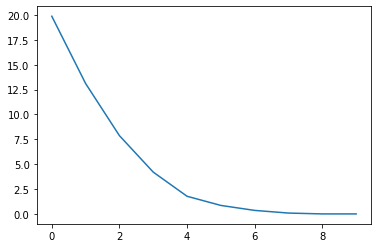

In [7]:
#ll = 0.5 * torch.ones(3,5, device=device)
ll = 0.5
print('lambda = \n', ll)

# Using L1Loss with prox
l1loss = L1Loss(lw=torch.tensor(ll))
X = torch.autograd.Variable(torch.randn(D.shape, device=device), requires_grad=True)
optimizer = torch.optim.SGD([X], lr = 1e0)

t0 = time()
num_iter = 10
display_step = 1
history_loss_prox = []
for iter in range(num_iter):
    loss = l1loss(X - D)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history_loss_prox.append(loss.item())

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, loss.item()))

print('D = \n', D)
print('X = \n', X)
import matplotlib.pyplot as plt
plt.plot(history_loss_prox)

lambda = 
 0.5
[  1/30]: loss = 20.9042,  
[  2/30]: loss = 14.2056,  
[  3/30]: loss = 9.0540,  
[  4/30]: loss = 6.4542,  
[  5/30]: loss = 4.6621,  
[  6/30]: loss = 5.0203,  
[  7/30]: loss = 3.6621,  
[  8/30]: loss = 4.4098,  
[  9/30]: loss = 3.1621,  
[ 10/30]: loss = 4.3379,  
[ 11/30]: loss = 3.1621,  
[ 12/30]: loss = 4.3379,  
[ 13/30]: loss = 3.1621,  
[ 14/30]: loss = 4.3379,  
[ 15/30]: loss = 3.1621,  
[ 16/30]: loss = 4.3379,  
[ 17/30]: loss = 3.1621,  
[ 18/30]: loss = 4.3379,  
[ 19/30]: loss = 3.1621,  
[ 20/30]: loss = 4.3379,  
[ 21/30]: loss = 3.1621,  
[ 22/30]: loss = 4.3379,  
[ 23/30]: loss = 3.1621,  
[ 24/30]: loss = 4.3379,  
[ 25/30]: loss = 3.1621,  
[ 26/30]: loss = 4.3379,  
[ 27/30]: loss = 3.1621,  
[ 28/30]: loss = 4.3379,  
[ 29/30]: loss = 3.1621,  
[ 30/30]: loss = 4.3379,  
D = 
 tensor([[[ 1.0594,  0.0580, -0.5124, -1.2920, -0.4186],
         [ 1.9617, -0.0399, -1.3206, -1.9506,  0.5958],
         [ 0.5408,  0.5340,  0.6775,  1.4387,  0.2808]]

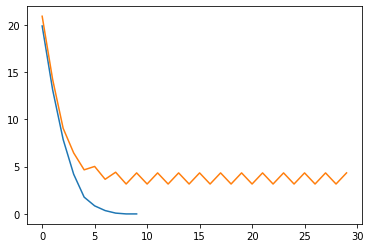

In [8]:
#ll = 0.5 * torch.ones(3,5, device=device)
ll = 0.5
print('lambda = \n', ll)

# Using sum of abs with autogradient
l1loss = lambda x: torch.sum(torch.abs(x)*ll)
X = torch.autograd.Variable(torch.randn(D.shape, device=device), requires_grad=True)
optimizer = torch.optim.SGD([X], lr = 1e0)

t0 = time()
num_iter = 30
display_step = 1
history_loss = []
for iter in range(num_iter):
    loss = l1loss(X - D)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history_loss.append(loss.item())

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, loss.item()))

print('D = \n', D)
print('X = \n', X)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history_loss_prox)
plt.plot(history_loss)